In [1]:
import pandas as pd

# Load the dataset to inspect its structure and contents
data = pd.read_csv("Flights Data.csv")
# Display the first few rows and a summary of the dataset to understand its structure
data.head(), data.info(), data.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 32 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   FL_DATE                  100000 non-null  object 
 1   AIRLINE                  100000 non-null  object 
 2   AIRLINE_DOT              100000 non-null  object 
 3   AIRLINE_CODE             100000 non-null  object 
 4   DOT_CODE                 100000 non-null  int64  
 5   FL_NUMBER                100000 non-null  int64  
 6   ORIGIN                   100000 non-null  object 
 7   ORIGIN_CITY              100000 non-null  object 
 8   DEST                     100000 non-null  object 
 9   DEST_CITY                100000 non-null  object 
 10  CRS_DEP_TIME             100000 non-null  int64  
 11  DEP_TIME                 97424 non-null   float64
 12  DEP_DELAY                97423 non-null   float64
 13  TAXI_OUT                 97382 non-null   float64
 14  WHEEL

(      FL_DATE                 AIRLINE                 AIRLINE_DOT  \
 0  2019-03-01           Allegiant Air           Allegiant Air: G4   
 1  2021-02-16  American Airlines Inc.  American Airlines Inc.: AA   
 2  2022-04-12       PSA Airlines Inc.       PSA Airlines Inc.: OH   
 3  2021-10-13  Southwest Airlines Co.  Southwest Airlines Co.: WN   
 4  2022-06-05  Southwest Airlines Co.  Southwest Airlines Co.: WN   
 
   AIRLINE_CODE  DOT_CODE  FL_NUMBER ORIGIN                     ORIGIN_CITY  \
 0           G4     20368       1668    PGD                 Punta Gorda, FL   
 1           AA     19805       2437    DFW           Dallas/Fort Worth, TX   
 2           OH     20397       5560    EWN  New Bern/Morehead/Beaufort, NC   
 3           WN     19393       1944    ABQ                 Albuquerque, NM   
 4           WN     19393       3081    PIT                  Pittsburgh, PA   
 
   DEST        DEST_CITY  ...  DIVERTED  CRS_ELAPSED_TIME  ELAPSED_TIME  \
 0  SPI  Springfield, IL  .

In [2]:
# Preprocessing the dataset

# Step 1: Handling Missing Values
# Fill missing delay reasons with 0 (assuming no delay for missing entries)
delay_columns = [
    'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT'
]
data[delay_columns] = data[delay_columns].fillna(0)

# Drop rows with missing DEP_DELAY and ARR_DELAY (essential for delay analysis)
data = data.dropna(subset=['DEP_DELAY', 'ARR_DELAY'])

# Step 2: Encoding Categorical Variables
# Encode categorical features like AIRLINE, ORIGIN, and DEST
encoded_data = pd.get_dummies(data, columns=['AIRLINE', 'ORIGIN', 'DEST'], drop_first=True)

# Step 3: Feature Engineering
# Extract flight hour from CRS_DEP_TIME and categorize into time blocks
def categorize_time(crs_time):
    hour = int(crs_time / 100)
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

data['TIME_OF_DAY'] = data['CRS_DEP_TIME'].apply(categorize_time)
encoded_data['TIME_OF_DAY'] = pd.Categorical(data['TIME_OF_DAY']).codes

# Step 4: Select Relevant Features for Predictive Modeling
selected_features = ['CRS_DEP_TIME', 'DISTANCE', 'TIME_OF_DAY', 'DELAY_DUE_CARRIER',
                     'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
                     'DELAY_DUE_LATE_AIRCRAFT', 'DEP_DELAY']
prepared_data = encoded_data[selected_features]

# Display prepared data's summary
prepared_data.info(), prepared_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97148 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CRS_DEP_TIME             97148 non-null  int64  
 1   DISTANCE                 97148 non-null  float64
 2   TIME_OF_DAY              97148 non-null  int8   
 3   DELAY_DUE_CARRIER        97148 non-null  float64
 4   DELAY_DUE_WEATHER        97148 non-null  float64
 5   DELAY_DUE_NAS            97148 non-null  float64
 6   DELAY_DUE_SECURITY       97148 non-null  float64
 7   DELAY_DUE_LATE_AIRCRAFT  97148 non-null  float64
 8   DEP_DELAY                97148 non-null  float64
dtypes: float64(7), int64(1), int8(1)
memory usage: 6.8 MB


(None,
    CRS_DEP_TIME  DISTANCE  TIME_OF_DAY  DELAY_DUE_CARRIER  DELAY_DUE_WEATHER  \
 0           630     994.0            2                0.0                0.0   
 2           625     221.0            2                0.0                0.0   
 3          1715     349.0            1               10.0                0.0   
 4           535     554.0            2                0.0                0.0   
 5          1140     954.0            2                0.0                0.0   
 
    DELAY_DUE_NAS  DELAY_DUE_SECURITY  DELAY_DUE_LATE_AIRCRAFT  DEP_DELAY  
 0            0.0                 0.0                      0.0      -10.0  
 2            0.0                 0.0                      0.0       -7.0  
 3            0.0                 0.0                      6.0       25.0  
 4            0.0                 0.0                      0.0        0.0  
 5            0.0                 0.0                      0.0       -2.0  )

C:\ProgramData\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


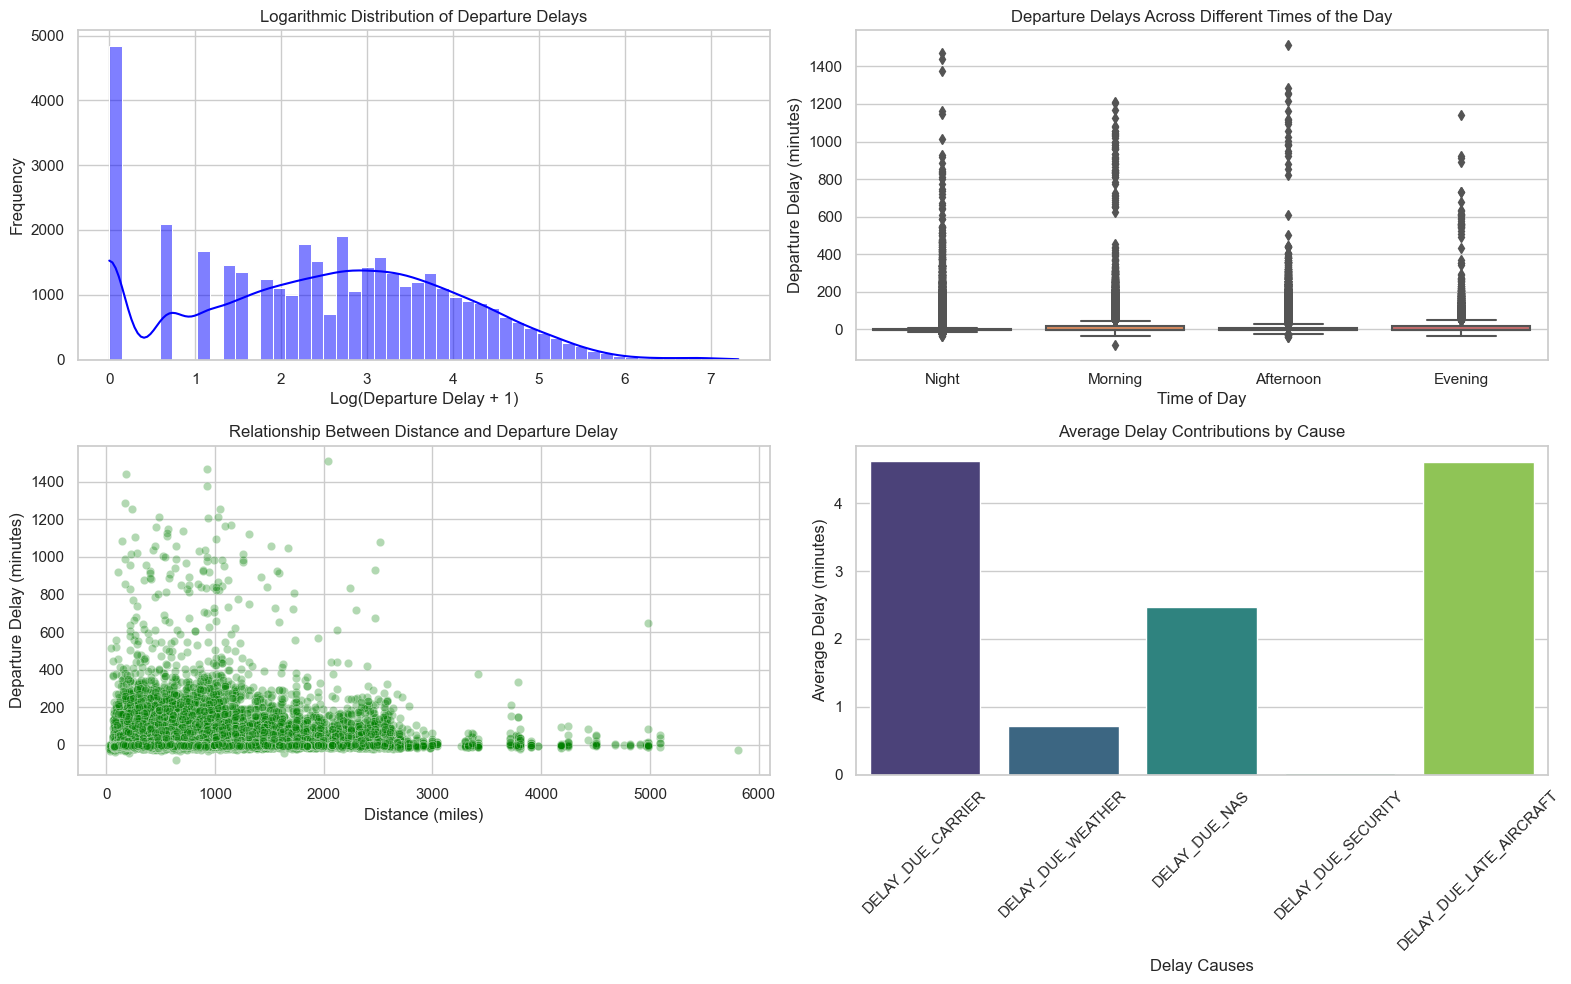

In [3]:
# Re-importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the visual style
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(16, 10))

# 1. Logarithmic Distribution of Departure Delays
plt.subplot(2, 2, 1)
log_dep_delay = np.log1p(prepared_data['DEP_DELAY'])  # Apply logarithmic transformation
sns.histplot(log_dep_delay, bins=50, kde=True, color='blue')
plt.title('Logarithmic Distribution of Departure Delays')
plt.xlabel('Log(Departure Delay + 1)')
plt.ylabel('Frequency')

# 2. Departure Delays Across Different Times of the Day
plt.subplot(2, 2, 2)
sns.boxplot(x=data['TIME_OF_DAY'], y=prepared_data['DEP_DELAY'], palette='muted')
plt.title('Departure Delays Across Different Times of the Day')
plt.xlabel('Time of Day')
plt.ylabel('Departure Delay (minutes)')

# Customize x-axis labels for time of day
time_of_day_labels = ['Night', 'Morning', 'Afternoon', 'Evening']
plt.xticks(ticks=range(len(time_of_day_labels)), labels=time_of_day_labels)

# 3. Relationship Between Distance and Departure Delay
plt.subplot(2, 2, 3)
sns.scatterplot(x=prepared_data['DISTANCE'], y=prepared_data['DEP_DELAY'], alpha=0.3, color='green')
plt.title('Relationship Between Distance and Departure Delay')
plt.xlabel('Distance (miles)')
plt.ylabel('Departure Delay (minutes)')

# 4. Average Delay Contributions by Cause
plt.subplot(2, 2, 4)
causes = prepared_data[['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
                        'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']].mean()
sns.barplot(x=causes.index, y=causes.values, palette='viridis')
plt.title('Average Delay Contributions by Cause')
plt.ylabel('Average Delay (minutes)')
plt.xlabel('Delay Causes')
plt.xticks(rotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

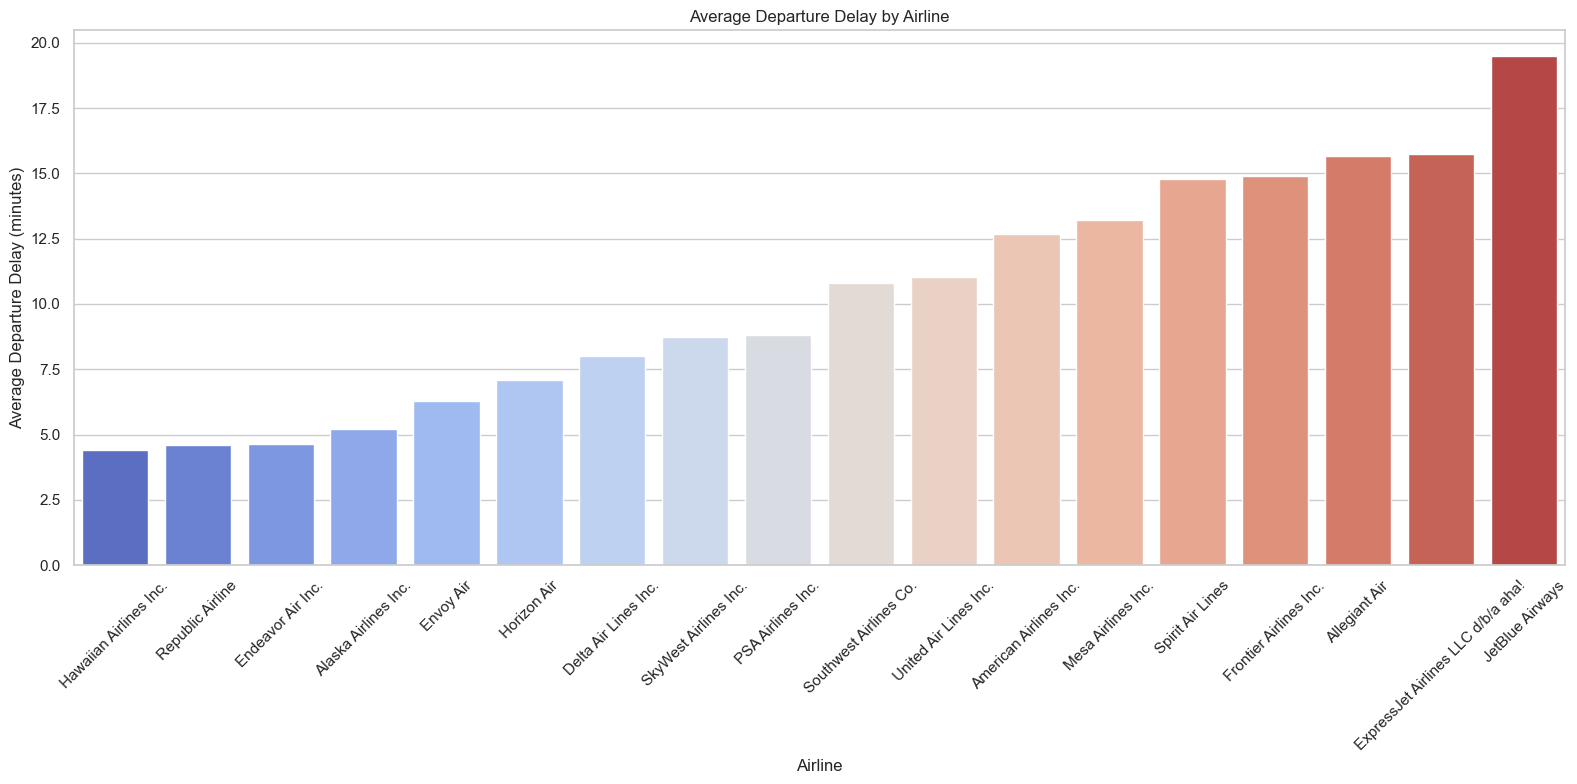

In [4]:
# Analyzing trends for airlines
plt.figure(figsize=(16, 8))

# Calculate the average departure delay per airline
airline_delay_trends = data.groupby('AIRLINE')['DEP_DELAY'].mean().sort_values()

# 1. Average Departure Delay by Airline
sns.barplot(x=airline_delay_trends.index, y=airline_delay_trends.values, palette='coolwarm')
plt.title('Average Departure Delay by Airline')
plt.xlabel('Airline')
plt.ylabel('Average Departure Delay (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Mean Absolute Error: 6.62
R� Score: 0.94


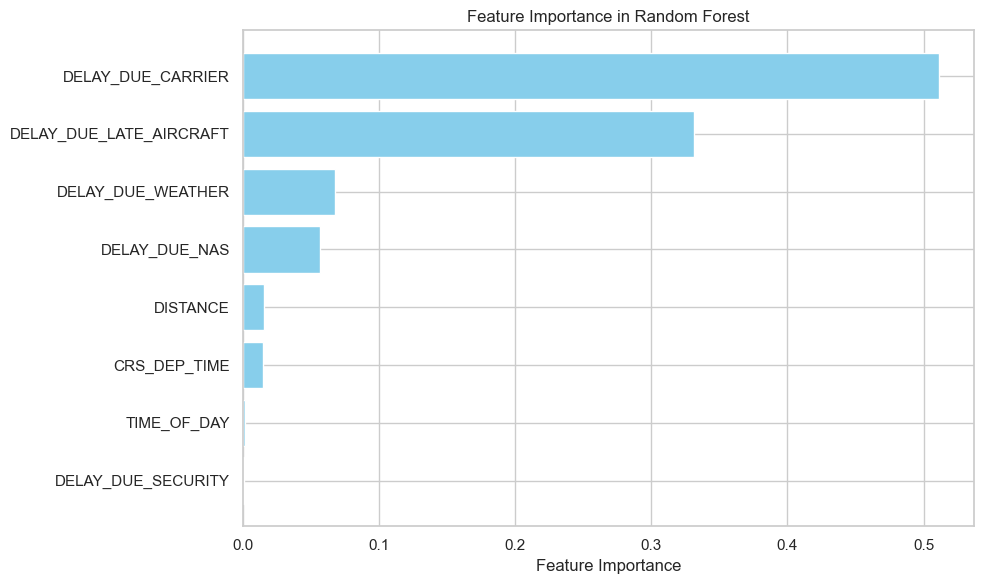

In [5]:
# Importing necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Step 1: Splitting data into features and target variable
X = prepared_data.drop(columns=['DEP_DELAY'])  # Features
y = prepared_data['DEP_DELAY']                # Target (Delay)

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Train a Random Forest Regressor with Default Parameters
# Keeping it simple with default settings
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 3: Make Predictions and Evaluate
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R� Score: {r2:.2f}")

# Step 4: Analyze Feature Importance
import matplotlib.pyplot as plt
import pandas as pd

# Extract feature importances
feature_importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to show most important features at the top
plt.tight_layout()
plt.show()

Model Evaluation Results:
Random Forest Regressor: MAE = 6.62, R² = 0.94
Gradient Boosting Regressor: MAE = 5.94, R² = 0.96
Support Vector Regressor: MAE = 14.50, R² = 0.22


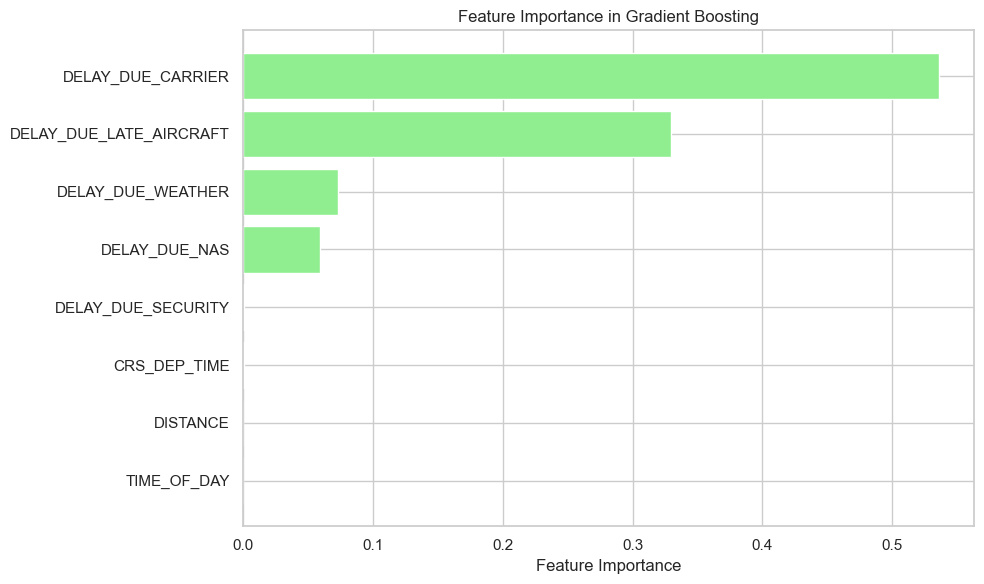

In [6]:
# Import necessary libraries for additional models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Create a function to evaluate a model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, r2

# Initialize Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_mae, gb_r2 = evaluate_model(gb_model, X_train, X_test, y_train, y_test)

# Initialize Support Vector Regressor
svr_model = SVR()
svr_mae, svr_r2 = evaluate_model(svr_model, X_train, X_test, y_train, y_test)

# Display results
print("Model Evaluation Results:")
print(f"Random Forest Regressor: MAE = {mae:.2f}, R² = {r2:.2f}")
print(f"Gradient Boosting Regressor: MAE = {gb_mae:.2f}, R² = {gb_r2:.2f}")
print(f"Support Vector Regressor: MAE = {svr_mae:.2f}, R² = {svr_r2:.2f}")

# Feature Importance for Gradient Boosting
gb_importances = gb_model.feature_importances_
gb_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': gb_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances for Gradient Boosting
plt.figure(figsize=(10, 6))
plt.barh(gb_importances_df['Feature'], gb_importances_df['Importance'], color='lightgreen')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Gradient Boosting')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [19]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import tkinter as tk
from tkinter import ttk

# Step 1: Load the dataset
data = pd.read_csv("Flights Data.csv")  # Ensure this file is in the same directory or provide the correct path

# Step 2: Preprocess the dataset
# Fill missing delay reasons with 0 (assuming no delay for missing entries)
delay_columns = [
    'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT'
]
data[delay_columns] = data[delay_columns].fillna(0)

# Drop rows with missing DEP_DELAY and ARR_DELAY (essential for delay analysis)
data = data.dropna(subset=['DEP_DELAY', 'ARR_DELAY'])

# Encode categorical features
encoded_data = pd.get_dummies(data, columns=['AIRLINE', 'ORIGIN', 'DEST'], drop_first=True)

# Extract flight hour from CRS_DEP_TIME and categorize into time blocks
def categorize_time(crs_time):
    hour = int(crs_time / 100)
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

data['TIME_OF_DAY'] = data['CRS_DEP_TIME'].apply(categorize_time)
encoded_data['TIME_OF_DAY'] = pd.Categorical(data['TIME_OF_DAY']).codes

# Select relevant features for predictive modeling
selected_features = ['CRS_DEP_TIME', 'DISTANCE', 'TIME_OF_DAY', 'DELAY_DUE_CARRIER',
                     'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
                     'DELAY_DUE_LATE_AIRCRAFT', 'DEP_DELAY']
prepared_data = encoded_data[selected_features]

# Step 3: Train the Gradient Boosting model
X = prepared_data.drop(columns=['DEP_DELAY'])
y = prepared_data['DEP_DELAY']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

# Step 4: Create the Tkinter interface for user input
def get_user_input():
    passenger_name = name_entry.get()
    origin = origin_var.get()
    destination = dest_var.get()
    airline = airline_var.get()
    distance = float(distance_entry.get())
    crs_dep_time = int(dep_time_entry.get())

    # Categorize time of day
    time_of_day = categorize_time(crs_dep_time)
    time_of_day_code = {'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Night': 3}[time_of_day]
    
    # Prepare input data
    input_data = pd.DataFrame({
        'CRS_DEP_TIME': [crs_dep_time],
        'DISTANCE': [distance],
        'TIME_OF_DAY': [time_of_day_code],
    })
    
    # Include dummy variables for categorical features
    for col in ['AIRLINE', 'ORIGIN', 'DEST']:
        input_data[col] = [airline if col == 'AIRLINE' else (origin if col == 'ORIGIN' else destination)]
    input_data_encoded = pd.get_dummies(input_data).reindex(columns=X.columns, fill_value=0)
    
    return input_data_encoded, passenger_name

def predict_delay():
    user_input, passenger_name = get_user_input()
    prediction = gb_model.predict(user_input)
    result_label.config(text=f"Predicted Delay for {passenger_name}: {prediction[0]:.2f} minutes")

# Step 5: Setup Tkinter window
root = tk.Tk()
root.title("Flight Delay Predictor")

# Passenger Name
tk.Label(root, text="Enter Passenger Name:").grid(row=0, column=0, padx=10, pady=5)
name_entry = tk.Entry(root)
name_entry.grid(row=0, column=1, padx=10, pady=5)

# Origin City Dropdown
tk.Label(root, text="Select Origin City:").grid(row=1, column=0, padx=10, pady=5)
origin_var = tk.StringVar()
origin_dropdown = ttk.Combobox(root, textvariable=origin_var)
origin_dropdown['values'] = data['ORIGIN'].unique().tolist()
origin_dropdown.grid(row=1, column=1, padx=10, pady=5)

# Destination City Dropdown
tk.Label(root, text="Select Destination City:").grid(row=2, column=0, padx=10, pady=5)
dest_var = tk.StringVar()
dest_dropdown = ttk.Combobox(root, textvariable=dest_var)
dest_dropdown['values'] = data['DEST'].unique().tolist()
dest_dropdown.grid(row=2, column=1, padx=10, pady=5)

# Airline Dropdown
tk.Label(root, text="Select Airline:").grid(row=3, column=0, padx=10, pady=5)
airline_var = tk.StringVar()
airline_dropdown = ttk.Combobox(root, textvariable=airline_var)
airline_dropdown['values'] = data['AIRLINE'].unique().tolist()
airline_dropdown.grid(row=3, column=1, padx=10, pady=5)

# Distance
tk.Label(root, text="Enter Flight Distance (miles):").grid(row=4, column=0, padx=10, pady=5)
distance_entry = tk.Entry(root)
distance_entry.grid(row=4, column=1, padx=10, pady=5)

# Scheduled Departure Time
tk.Label(root, text="Enter Scheduled Departure Time (HHMM):").grid(row=5, column=0, padx=10, pady=5)
dep_time_entry = tk.Entry(root)
dep_time_entry.grid(row=5, column=1, padx=10, pady=5)

# Prediction Button
predict_button = tk.Button(root, text="Predict Delay", command=predict_delay)
predict_button.grid(row=6, column=0, columnspan=2, pady=10)

# Result Label
result_label = tk.Label(root, text="Predicted Delay: ")
result_label.grid(row=7, column=0, columnspan=2, pady=10)

# Run the Tkinter event loop
root.mainloop()
